In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import operator
import math
from scipy.spatial import distance
from matplotlib import pyplot

In [2]:
def withSupport(x, expr):
    if abs(x) <= 1.0:
        return expr
    else:
        return 0.0 

In [3]:
def uniform(x):
    return withSupport(x, 0.5)

In [4]:
def triangular(x):
    return withSupport(x, 1 - abs(x))

In [5]:
def epanechnikov(x):
    return withSupport(x, 0.75 * ((1 - x ** 2) ** 2))

In [6]:
def quartic(x):
    return withSupport(x, 15.0/16.0 * (1 - x ** 2))

In [7]:
def triweight(x):
    return withSupport(x, 35.0/32.0 * ((1 - x ** 2) ** 3))

In [8]:
def tricube(x):
    return withSupport(x, 70.0/81.0 * ((1 - abs(x) ** 3) ** 3))

In [9]:
def gaussian(x):
    return 1 / math.sqrt(2.0 * math.pi) * math.exp(-0.5 * (x ** 2))

In [10]:
def cosine(x):
    return withSupport(x, math.pi / 4.0 * math.cos(math.pi / 2.0 * x))

In [11]:
def logistic(x):
    if abs(x) <= 12.0:
        return 1 / (math.exp(x) + 2.0 + math.exp(-x))
    else:
        return 0.0

In [12]:
def sigmoid(x):
    if abs(x) <= 12.0:
        return 2.0 / math.pi * 1 / (math.exp(x) + math.exp(-x))
    else:
        return 0.0

In [13]:
def silverman(x):
    return 0.5 * math.exp(-x / math.sqrt(2)) * math.sin(x / math.sqrt(2.0) + math.pi / 4.0)

In [14]:
allKernels = {
    "logistic" : logistic, 
    "uniform" : uniform, 
    "triangular" : triangular,
    "epanechnikov" : epanechnikov,
    "quartic" : quartic, 
    "triweight" : triweight, 
    "tricube" : tricube, 
    "gaussian" : gaussian, 
    "cosine" : cosine, 
    "sigmoid" : sigmoid, 
    "silverman" : silverman,
    "id" : id
}

In [15]:
allDistances = {
    "manhattan" : distance.cityblock,
    "euclidian" : distance.euclidean,
}

In [48]:
def readNormalizedData(file):
    df = pd.read_csv(file, sep=",").drop(columns="LRS-name")
    classes = df["LRS-class"].to_numpy()
    features = df.drop(columns="LRS-class").to_numpy()
    objects = []
    for i in range(len(classes)):
        objects.append({'class' : classes[i], 'vector': features[i]})
    for j in range(len(objects[0]['vector'])):
        s = 0.0
        for i in range(len(objects)):
            s += objects[i]['vector'][j]
        for i in range(len(objects)):
            objects[i]['vector'][j] /= s
    return objects

In [49]:
def splitData(objects, l):
    for obj in objects:
        pyplot.scatter([obj['vector'][0]], [obj['vector'][1]], c = obj['class'])
    pyplot.show()
    
    n = max(objects, key=lambda obj: obj['class'])['class'] + 1
    
    cnt = [0 for i in range(n)]
    for obj in objects:
        cnt[obj['class']] += 1
    pyplot.plot(range(n), cnt)
    pyplot.show()
    
    train = []
    test = []
    for i in range(len(objects)):
        if i % l != l - 1:
            train.append(objects[i])
        else:
            test.append(objects[i])
    return train, test, n

In [50]:
def getData(file):
    return splitData(readNormalizedData(file), 5)

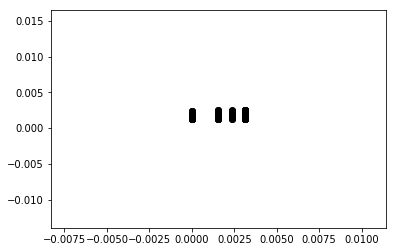

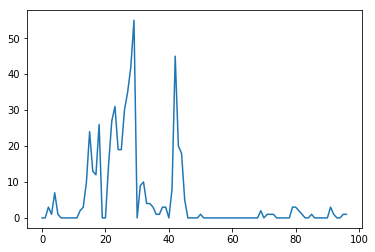

train size: 425 
test size: 106 
classes: 97 
features: 101


In [51]:
train, test, n = getData('kNN/spectrometer.csv')
print("train size:", len(train), "\ntest size:", len(test), "\nclasses:", n,"\nfeatures:",  len(train[0]['vector']))

In [52]:
def kNN(newVector, n, objects, h, kernel, dist):
    votes = [0.0 for i in range(n)]
    for obj in objects:
        c = obj['class']
        v = obj['vector']
        votes[c] += kernel(dist(newVector, v) / h)
    return np.argmax(votes)

In [53]:
def varKNN(newVector, n, objects, k, kernel, dist):
    votes = [0.0 for i in range(n)]
    objects2 = sorted(objects, key = lambda obj: dist(newVector, obj['vector']))
    distK = dist(newVector, objects2[int(k)]['vector'])
    for obj in objects:
        c = obj['class']
        v = obj['vector']
        votes[c] += kernel(dist(newVector, v) / distK)
    return np.argmax(votes)

In [54]:
def calcF(precision, recall):
    if precision != 0.0 or recall != 0.0:
        return 2.0 * precision * recall / (precision + recall)
    else:
        return 0.0

def fMeasure(cnt, n):
    selectedAndRelevant = [cnt[c][c] for c in range(n)]
    selected =  [sum([cnt[i][c] for i in range(n)]) for c in range(n)]
    relevant =  [sum(cnt[c]) for c in range(n)]
    precision =  [(selectedAndRelevant[c] / selected[c] if selected[c] != 0 else 0.0) for c in range(n)]
    recall =  [(selectedAndRelevant[c] / relevant[c] if relevant[c] != 0 else 0.0) for c in range(n)]
    f = [calcF(precision[c], recall[c]) for c in range(n)]
 
    total = sum([sum(row) for row in cnt])
    weightedF = sum([f[c] * relevant[c] for c in range(n)]) / total
    weightedPrecision = sum([precision[c] * relevant[c] for c in range(n)]) / total
    weightedRecall = sum([recall[c] * relevant[c] for c in range(n)]) / total

    return calcF(weightedPrecision, weightedRecall)

In [55]:
def testAlgo(test, n, classifier):
    cnt = [[0.0 for i in range(n)] for j in range(n)]
    for t in test:
        c = classifier(t['vector'])
        cnt[t['class']][c] += 1.0
    return fMeasure(cnt, n)

In [56]:
classifier = lambda v: kNN(v, n, train, 10.0, uniform, distance.cityblock)
f = testAlgo(test, n, classifier)
print(f)

0.006064690026954178


In [57]:
def gridSearch(f, l, r, eps):
    if abs(r - l) < eps:
        return [], l, -1e100
    res = []
    bestX, best = l, -1e100
    for x in [l + i / 10 * (r - l) for i in range(11)]:
        y = f(x)
        res.append({'x': x, 'y' : y})
        if y > best:
            bestX = x
            best = y
    res2, newBestX, newBest = gridSearch(f, max(l, bestX - (r - l) / 10), min(r, bestX + (r - l) / 10), eps)
    if newBest > best:
        best = newBest
        bestX = newBestX
    return res + res2, bestX, best

manhattan uniform h =  0.029900000000000003 f =  0.32267621418883213 



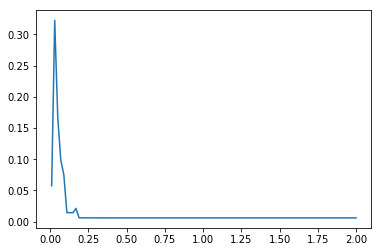

euclidian uniform h =  0.01 f =  0.026089955170205428 



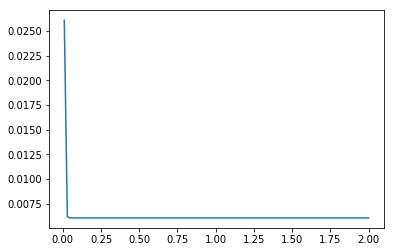

manhattan quartic h =  0.029900000000000003 f =  0.3112875038780753 



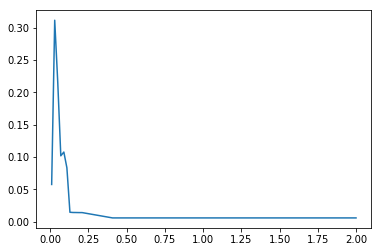

euclidian quartic h =  0.01 f =  0.1561490657119436 



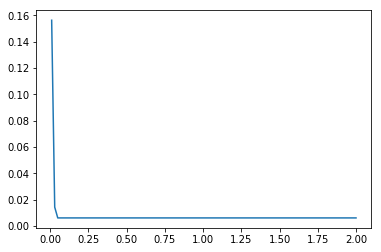

manhattan cosine h =  0.029900000000000003 f =  0.3112875038780753 



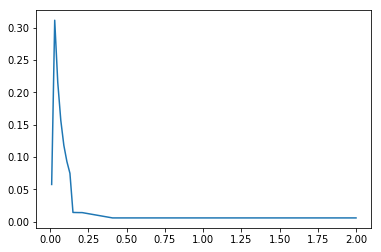

euclidian cosine h =  0.01 f =  0.1584879910906832 



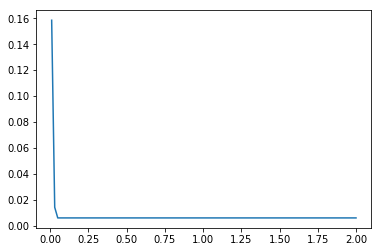

manhattan id h =  0.01 f =  0.006064690026954178 



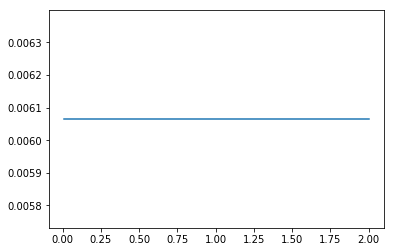

euclidian id h =  0.01 f =  0.006064690026954178 



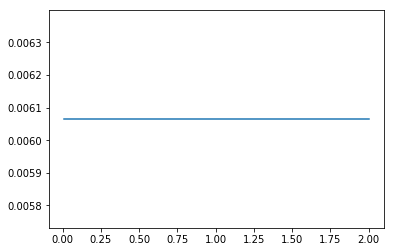

manhattan sigmoid h =  0.01 f =  0.29626047271984196 



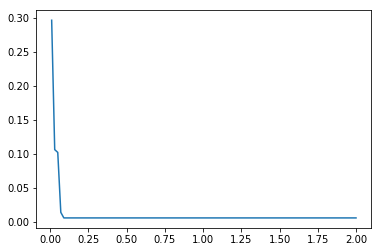

euclidian sigmoid h =  0.01 f =  0.014243433222345541 



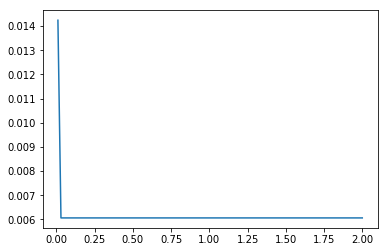

manhattan logistic h =  0.01 f =  0.22769727502109846 



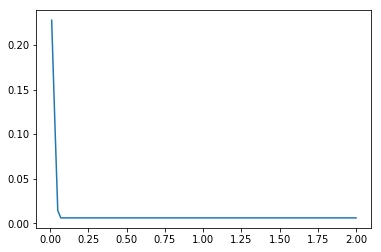

euclidian logistic h =  0.01 f =  0.006064690026954178 



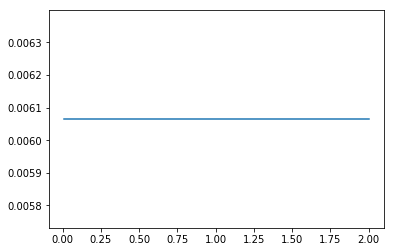

manhattan epanechnikov h =  0.029900000000000003 f =  0.37523298195627347 



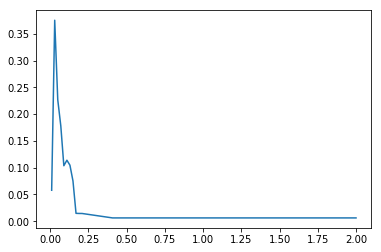

euclidian epanechnikov h =  0.01 f =  0.16792071266618447 



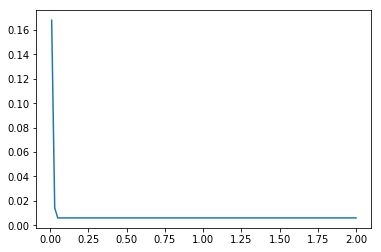

manhattan triweight h =  0.029900000000000003 f =  0.3838394534614083 



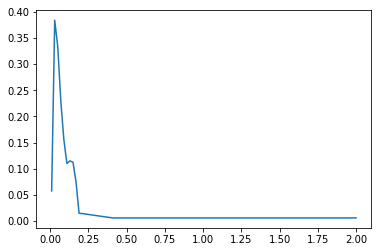

euclidian triweight h =  0.01 f =  0.18031890923331959 



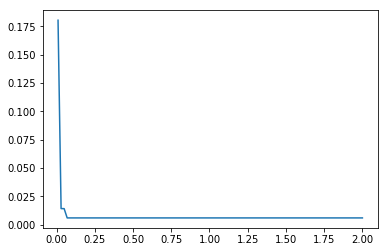

manhattan tricube h =  0.029900000000000003 f =  0.37530311009218037 



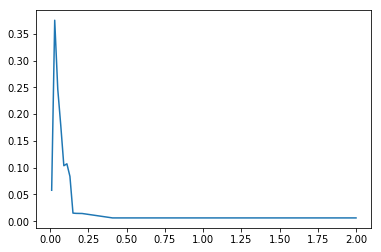

euclidian tricube h =  0.01 f =  0.1558760366857261 



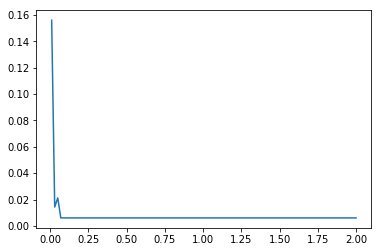

manhattan triangular h =  0.029900000000000003 f =  0.3361383699303821 



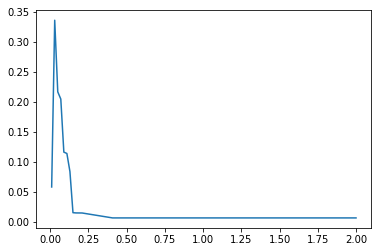

euclidian triangular h =  0.01 f =  0.1761326293246686 



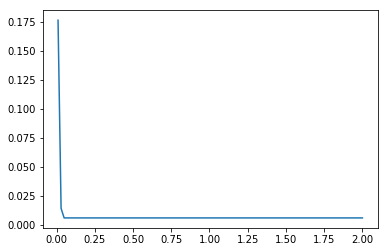

manhattan gaussian h =  0.01 f =  0.35647901952748273 



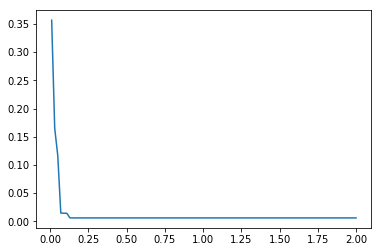

euclidian gaussian h =  0.01 f =  0.01429388221841052 



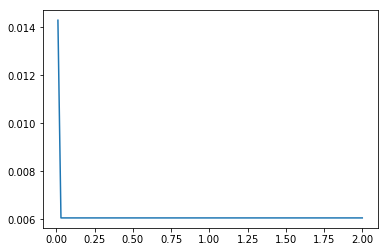

manhattan silverman h =  0.01 f =  0.3339650186350322 



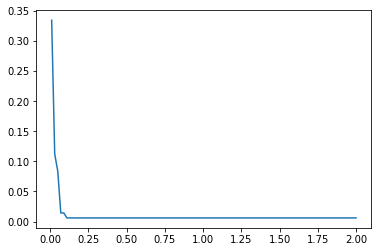

euclidian silverman h =  0.01 f =  0.014243433222345541 



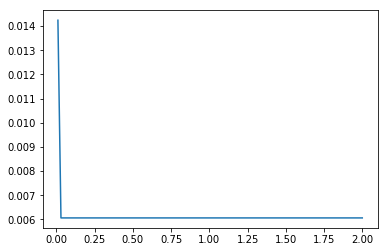

In [58]:
for kernelName in allKernels:
    kernel = allKernels[kernelName]
    for distName in allDistances:
        dist = allDistances[distName]
        
        f = lambda h: testAlgo(test, n, lambda v: kNN(v, n, train, h, kernel, dist))
        res, bestH, f = gridSearch(f, 0.01, 2.0, 0.05)
        
        xs = []
        ys = []
        for obj in sorted(res, key = lambda obj : obj['x']):
            xs.append(obj['x'])
            ys.append(obj['y'])
        
        print(distName, kernelName, "h = ", bestH, "f = ", f,'\n')
        
        pyplot.plot(xs, ys)
        pyplot.show()

manhattan uniform k =  4.84 f =  0.41307908630458173 



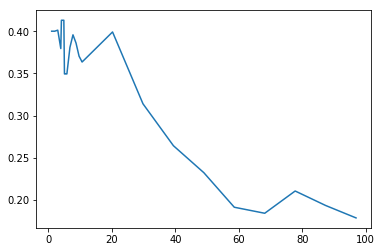

euclidian uniform k =  3.88 f =  0.2851065957334681 



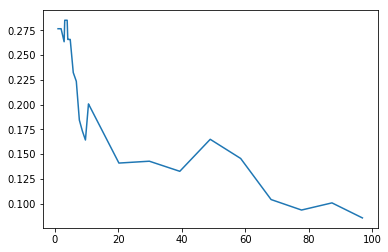

manhattan quartic k =  39.4 f =  0.38780324068383887 



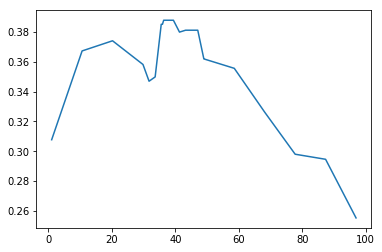

euclidian quartic k =  3.88 f =  0.31380459005723926 



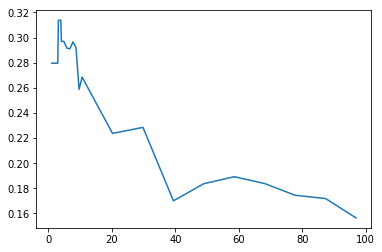

manhattan cosine k =  41.32 f =  0.38780324068383887 



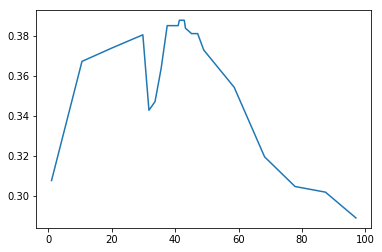

euclidian cosine k =  3.304 f =  0.31380459005723926 



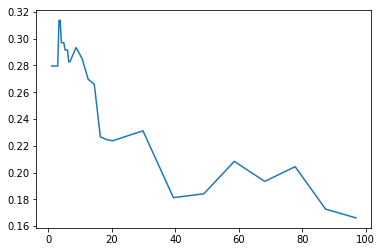

manhattan id k =  1.0 f =  0.006064690026954178 



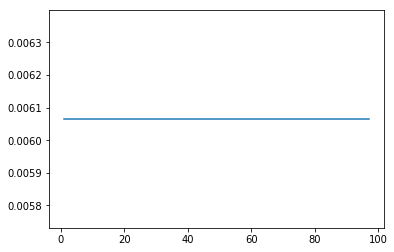

euclidian id k =  1.0 f =  0.006064690026954178 



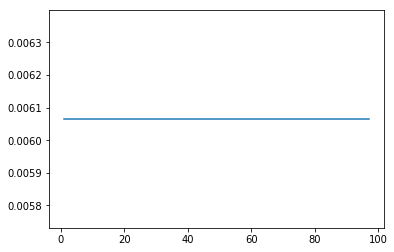

manhattan sigmoid k =  1.0 f =  0.18334147874048734 



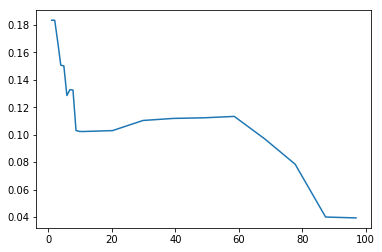

euclidian sigmoid k =  1.0 f =  0.19355553357359057 



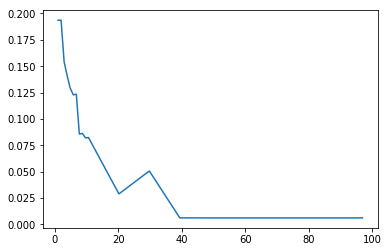

manhattan logistic k =  1.0 f =  0.18306274050117968 



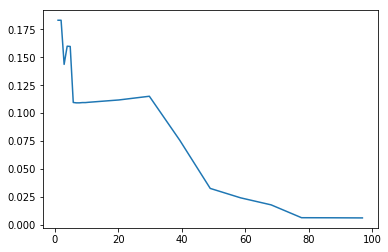

euclidian logistic k =  1.0 f =  0.14317755032864482 



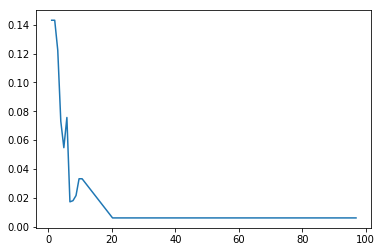

manhattan epanechnikov k =  22.12 f =  0.4030630070312346 



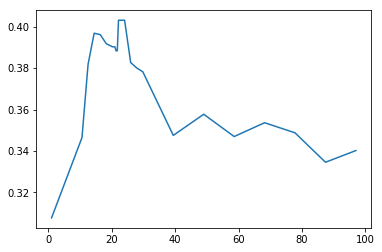

euclidian epanechnikov k =  8.68 f =  0.3129007147650245 



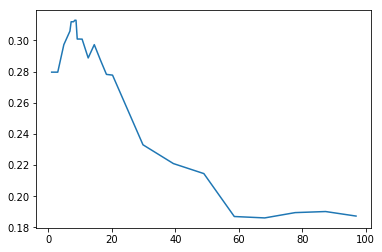

manhattan triweight k =  34.024 f =  0.3996575174340393 



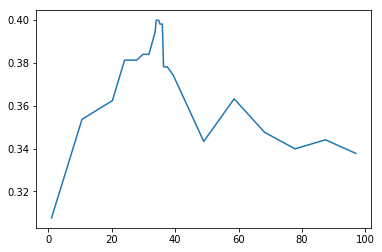

In [ ]:
for kernelName in allKernels:
    kernel = allKernels[kernelName]
    for distName in allDistances:
        dist = allDistances[distName]
        
        f = lambda k: testAlgo(test, n, lambda v: varKNN(v, n, train, k, kernel, dist))
        res, bestH, f = gridSearch(f, 1, n, 1)
        
        xs = []
        ys = []
        for obj in sorted(res, key = lambda obj : obj['x']):
            xs.append(obj['x'])
            ys.append(obj['y'])
        
        print(distName, kernelName, "k = ", bestH, "f = ", f,'\n')
        
        pyplot.plot(xs, ys)
        pyplot.show()